In [1]:
#code to validate GloFAS runnoff against JRA
import datetime
import math
import os
from datetime import datetime, timedelta
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas
import pandas as pd
import requests
import xarray
import xarray as xr
import xesmf
from boundary import *

In [2]:
#GloFAS original data:
gf = xr.open_dataset('/glade/work/gseijo/GloFAS/GloFAS_2000_2014.nc')
#GloFAS for CESM data:
gf_cesm = xr.open_dataset('/glade/work/gseijo/GloFAS/GloFAS_2000_2014_cesm.nc')
#JRA55 data:
jra = xr.open_mfdataset('/glade/p/cesmdata/cseg/inputdata/lnd/dlnd7/JRA55/JRA.v1.4.runoff.20*.nc',)

#outputs:
glofas_jra_full_domain = '/glade/work/gseijo/GloFAS/glofas_vs_jra_full_regional_domain_2000_2014.png'
glofas_jra_amazon      = '/glade/work/gseijo/GloFAS/glofas_vs_jra_amazon_2000_2014.png'

In [3]:
print(gf)
print('--------------')
print(gf_cesm)
print('--------------')
print(jra)

<xarray.Dataset>
Dimensions:     (latitude: 502, longitude: 1402, time: 5479)
Coordinates:
  * time        (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2014-12-31
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 40.05 39.95 39.85 ... -9.85 -9.95 -10.05
  * longitude   (longitude) float64 -110.1 -110.0 -109.9 ... 29.85 29.95 30.05
    valid_time  (time) datetime64[ns] ...
Data variables:
    dis24       (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-07-12T14:00 GRIB to CDM+CF via cfgrib-0.9.1...
--------------
<xarray.Dataset>
Dimensions:          (latitude: 420, longitude: 760, time: 5479)
Coordinates:
  * ti

In [4]:
#both the original GloFAS and the JRA data are Global...let's subset to our regional domain
#also make sure the time axes have the same bounds.
minlat      = np.min(gf_cesm.latitude.values)
maxlat      = np.max(gf_cesm.latitude.values)
minlon      = np.min(gf_cesm.longitude.values)
maxlon      = np.max(gf_cesm.longitude.values)
mintime     = np.min(gf_cesm.time)
maxtime     = np.max(gf_cesm.time)

gf['longitude'] = gf['longitude'] % 360
gf              = gf.sortby(gf.longitude)

gf          = gf.sel(latitude=slice(maxlat,minlat), longitude=slice(minlon,maxlon))
gf          = gf.sel(time=slice(mintime,maxtime))
jra         = jra.sel(latitude=slice(minlat,maxlat), longitude=slice(minlon,maxlon))
jra['time'] = jra.indexes['time'].to_datetimeindex()
jra         = jra.sel(time=slice(mintime,maxtime))

/glade/u/home/gseijo/miniconda3/envs/gridTools/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


In [10]:
#area weighted means:
def areaweighted_region_mean(dxr,latstr,lonstr):
    # given an xarray dataset <grid> for a given depth and time,
    # calculate the mean of the gridded data variable, weighted by grid cell area
    if latstr == 'latitude':
        bfr = dxr.latitude
    elif latstr == 'yh':
        bfr = dxr.yh
    weights = np.cos(np.deg2rad(bfr))
    weights.name = "weights"
    dxr_weighted = dxr.weighted(weights)
    
    return dxr_weighted.mean((lonstr, latstr))

gf_cesm_mean = areaweighted_region_mean(gf_cesm,'latitude','longitude')
jra_mean     = areaweighted_region_mean(jra,'latitude','longitude')

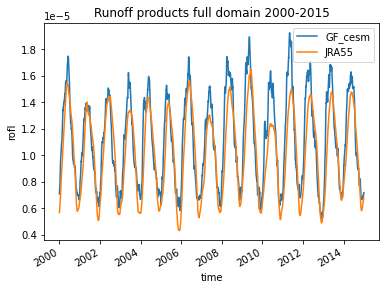

In [15]:
gf_cesm_mean['runoff'].plot(label='GF_cesm')
jra_mean['rofl'].plot(label='JRA55')
plt.title('Runoff full domain 2000-2015')
plt.legend()
plt.xlabel('')
plt.ylabel('runoff [kg/m2/s]')
plt.grid()
plt.savefig(glofas_jra_full_domain)

In [22]:
#do the same but subset to amazon river region only
gf_cesm_az = gf_cesm.sel(latitude=slice(2,-2),longitude=slice(308,312))
jra_az     = jra.sel(latitude=slice(-2,2),longitude=slice(308,312))

In [25]:
gf_cesm_az_mean = areaweighted_region_mean(gf_cesm_az,'latitude','longitude')
jra_az_mean     = areaweighted_region_mean(jra_az,'latitude','longitude')

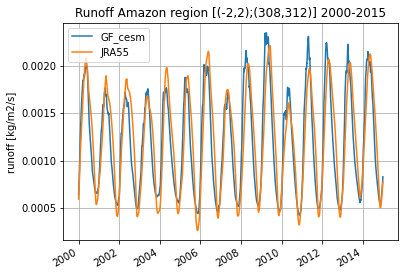

In [26]:
gf_cesm_az_mean['runoff'].plot(label='GF_cesm')
jra_az_mean['rofl'].plot(label='JRA55')
plt.title('Runoff Amazon region [(-2,2);(308,312)] 2000-2015')
plt.legend()
plt.xlabel('')
plt.ylabel('runoff [kg/m2/s]')
plt.grid()
plt.savefig(glofas_jra_amazon)

In [30]:
#do the same but subset to error region only
gf_cesm_err = gf_cesm.sel(latitude=slice(0.4,0.2),longitude=slice(311,313))
jra_err    = jra.sel(latitude=slice(0.2,0.4),longitude=slice(311,313))

In [31]:
gf_cesm_err_mean = areaweighted_region_mean(gf_cesm_err,'latitude','longitude')
jra_err_mean     = areaweighted_region_mean(jra_err,'latitude','longitude')

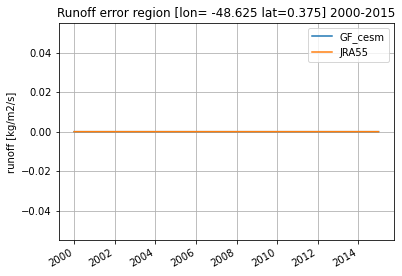

In [32]:
gf_cesm_err_mean['runoff'].plot(label='GF_cesm')
jra_err_mean['rofl'].plot(label='JRA55')
plt.title('Runoff error region [lon= -48.625 lat=0.375] 2000-2015')
plt.legend()
plt.xlabel('')
plt.ylabel('runoff [kg/m2/s]')
plt.grid()

(-5.0, 5.0)

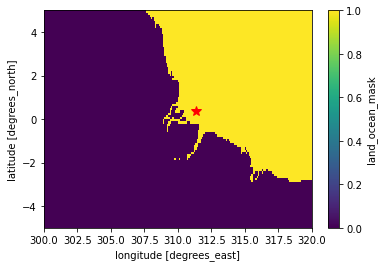

In [34]:
gf_cesm['land_ocean_mask'][:,:].plot()
plt.plot(360-48.625,0.375,'*',color='r',markersize=10)
plt.xlim([300,320])
plt.ylim([-5,5])